## Model loader class
Used for testing a model saved with TensorFlow `tf.train.saver()` method.

Extracts arguments from the model name.

NOTE: Only works with the standard convolutional network architecture referenced in our essay.

In [1]:
%matplotlib notebook

from loader import Loader

## Load model ##

In [2]:
# Input path to model found in `src/models/`
loader = Loader('256-8-5-256model.ckpt')

Parameters: ['256', '8', '5', '256']
Model restored from file: /Users/justinshenk/Projects/tensorflow/digits-classifier/src/models/256-8-5-256model.ckpt
[array([[  5.17689276, -14.5217104 ,  -6.96692848,  -5.0754714 ,
        -11.35671425,  -9.49446678,   3.26074338, -12.50344372,
         28.46101189,  -6.18828583],
       [ -4.77247238, -26.28050995,  -9.82460117,  -8.461833  ,
        -44.81344986,  32.96599197,  77.02778625, -18.16509056,
         16.971138  ,   4.83611298],
       [ 35.42481613, -13.09244347, -10.45859241,   7.5855546 ,
        -16.35520744, -19.07185936, -12.22659206, -18.04203224,
         10.40502834, -16.09779167],
       [ -5.02693701,  -8.43986893,  -6.90862989,  -1.92930639,
         48.65972137, -14.26018429,   4.21434116,  18.66361618,
         -3.24252748, -18.85608292],
       [-12.01536465, -14.7566843 , -17.12702751, -14.17032623,
        -17.88506889, -30.7776165 , -14.25467682, -25.42322922,
         61.73958588, -16.92560959]], dtype=float32)]


## Classify images using the model ##

Model restored from file: /Users/justinshenk/Projects/tensorflow/digits-classifier/src/models/256-8-5-256model.ckpt


<IPython.core.display.Javascript object>


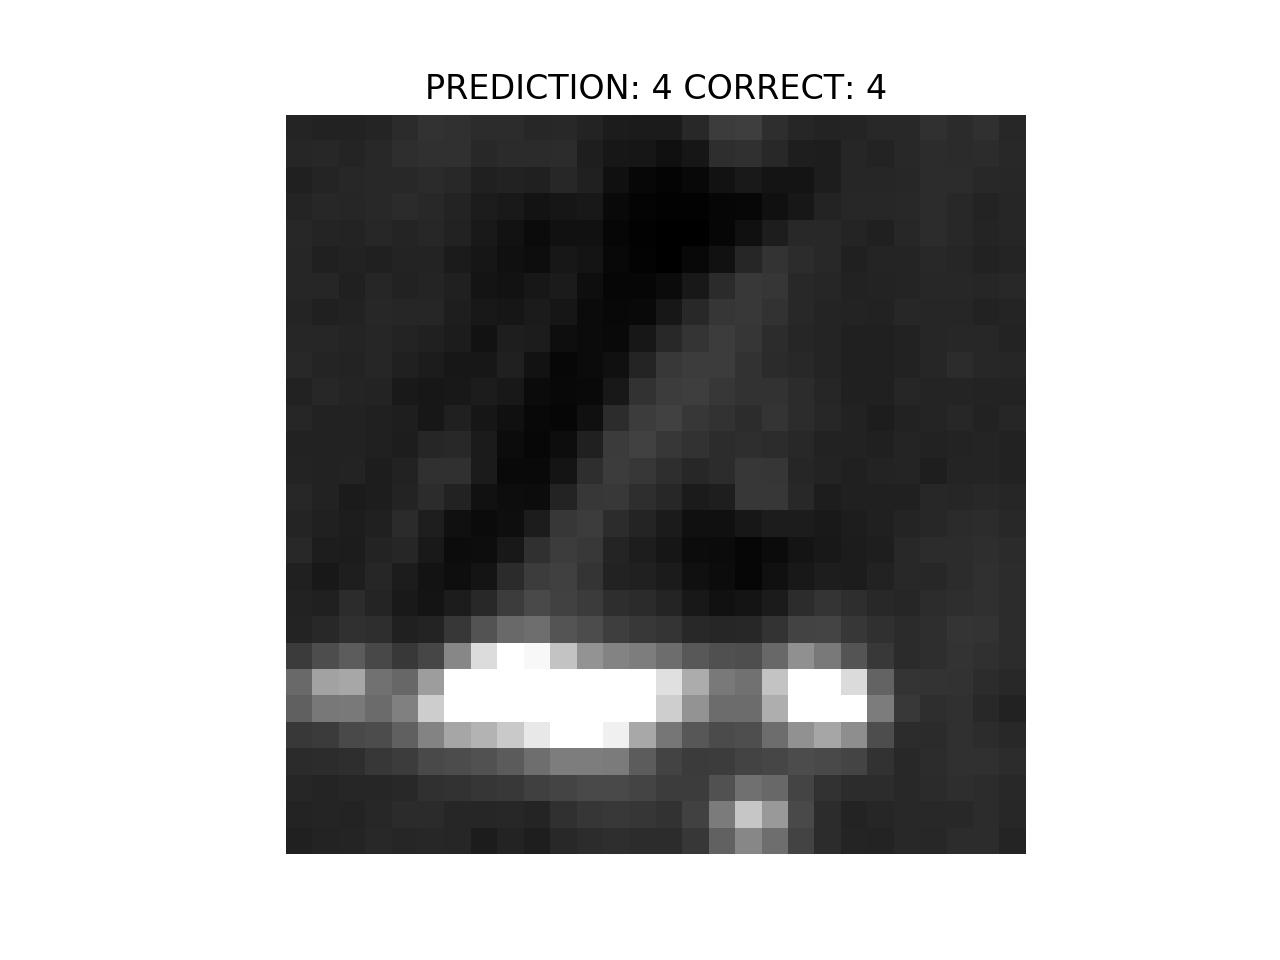

<IPython.core.display.Javascript object>


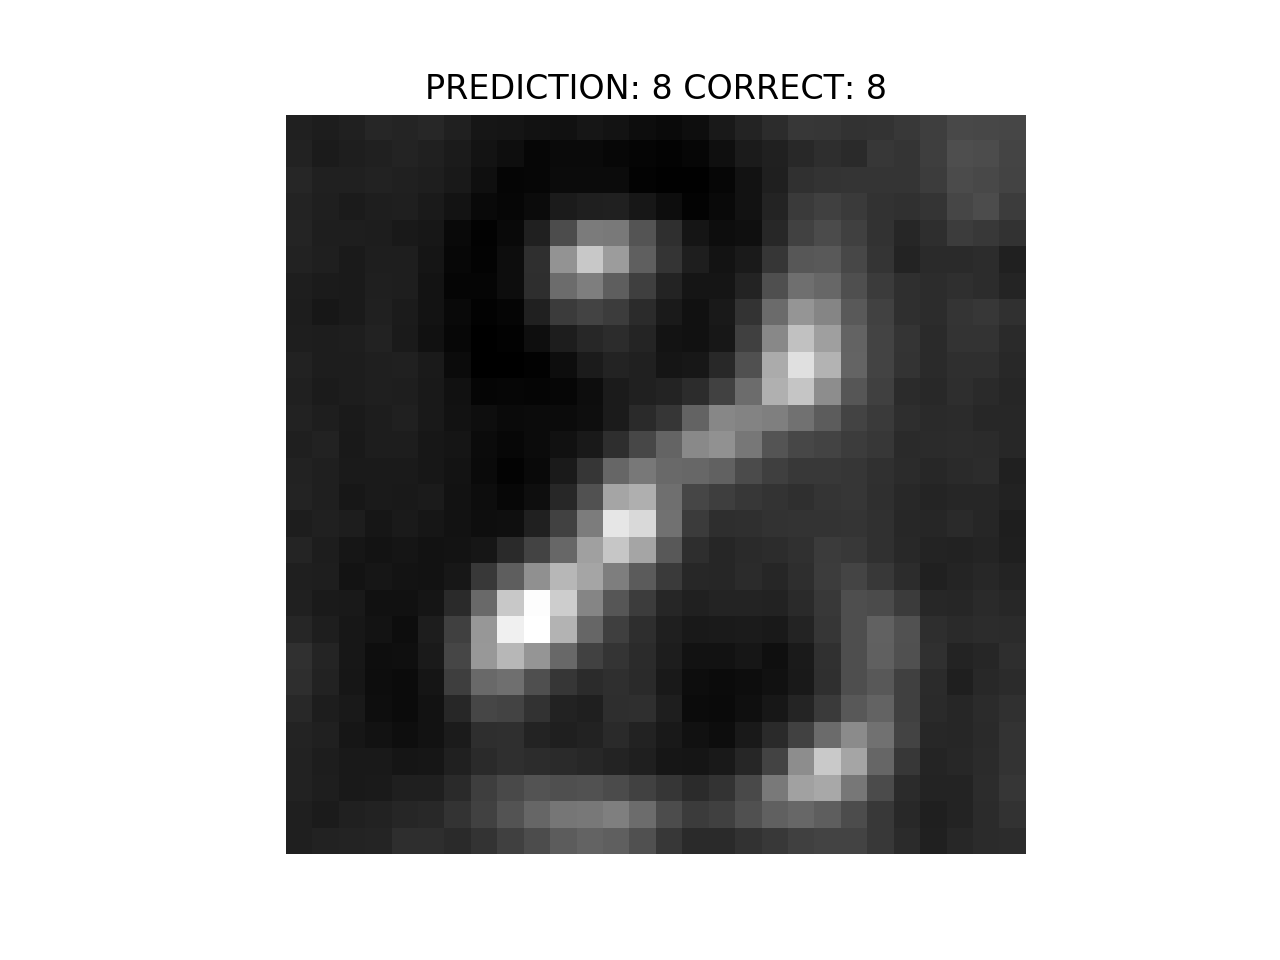

<IPython.core.display.Javascript object>


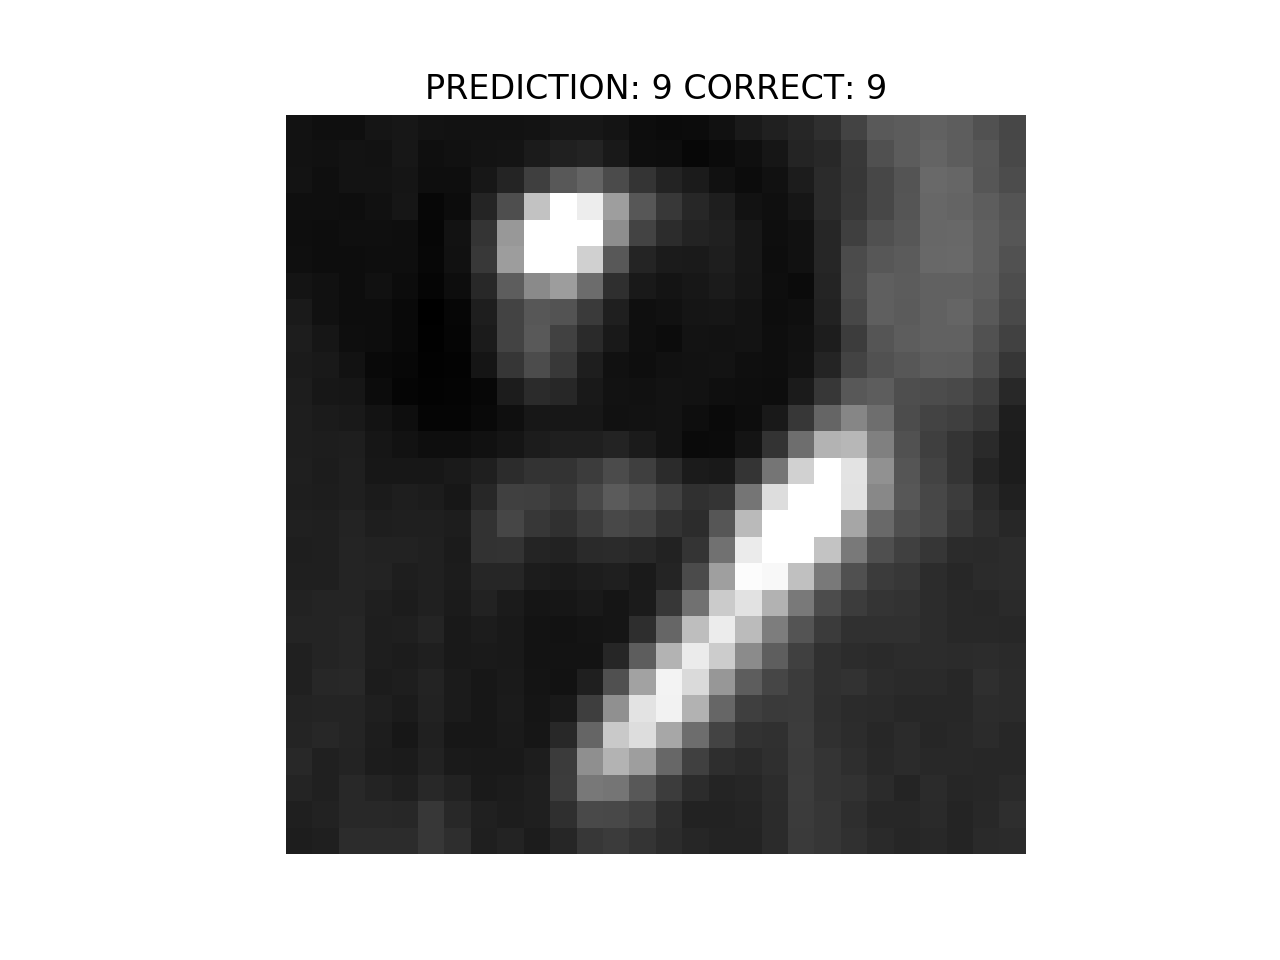

In [4]:
# Get test dataset
import pickle
test_images, test_labels = pickle.load(open('x_test.p','rb')), pickle.load(open('y_test.p','rb'))

loader.classify(test_images[
15:18].reshape(-1,784),test_labels[15:18],imshow=True)